## Set Up

**Author:** Tahmeed Tureen <<tureen@umich.edu>>

**Affitiliation:** Independent Researcher

**Word Count:**

**Note:** We add more than 2 figures in this notebook per Joris' message on Discord [here](https://discord.com/channels/1425024877311823922/1425030602247245855/1449014039001694339)

In [6]:
# The following code will load all relevant helper functions and Python packages
from src.skillcorner_pysport_hackathon_helpers import *

## 1 Introduction

Pep Guardiola has long been associated with positional football and deliberate, possession-driven tempo control. In a 2021 interview with Sky Sports, he emphasized that Manchester City’s defensive strength stems from dominating the ball: “The reason why [our defensive record is so good] is because 67 per cent of the time we have the ball… If you have the ball as much as possible then the opponent does not have the ball.” [[1](https://www.skysports.com/football/news/11662/12202414/pep-guardiola-exclusive-interview-possession-football-is-the-secret-of-man-citys-defensive-success)] This philosophy reflects a belief that slowing the tempo and sustaining possession can systematically destabilize opposing defenses through structure and control.

Yet, in January 2025, Guardiola offered a strikingly different and contrasting perspective when speaking with TNT Sports: “Today, modern football is the way Bournemouth, Newcastle, Brighton, and Liverpool play. Modern football is not positional. You have to rise to the rhythm.” [[2](https://www.nytimes.com/athletic/6623652/2025/09/26/tempo-in-football-analysis/)] Here, Guardiola gestures toward a more adaptive, rhythm-responsive style of play, where tempo becomes situational rather than fixed. In football practice, this notion of “rhythm” is most closely aligned with tempo — the speed at which teams progress the ball, whether through rapid forward movement or slower, possession-retaining sequences.

Taken together, these statements reveal a deeper tactical theme: elite performance may depend not on playing fast or slow, but on a player’s ability to flexibly adjust tempo in response to game context. Motivated by Guardiola's ever-changing perspectives on football, we propose a **novel** player-adjusted Bayesian hierarchical modeling framework to quantify individual differences in ball-tempo variability. Our goal is to provide a statistical lens for scouting players who demonstrate tempo flexibility — the capacity to dynamically speed up or slow down play — as well as identifying players whose in-game tempo remains comparatively rigid.

### 1.1 Read the Data


In [7]:
display(match_ids) # check if all 10 ids included

[1886347,
 1899585,
 1925299,
 1953632,
 1996435,
 2006229,
 2011166,
 2013725,
 2015213,
 2017461]

The following chunk of code will use multiple helper functions to directly read SkillCorner datasets, process them, create specific metrics, and then output four datasets we can use for our research project.

**Note:** This took ~4 minutes to run on my MacBook Air (M4)

In [8]:
model_df, poss_metrics, match_info, team_info = retrieveDataBatches(match_ids=match_ids)

***-- Reading & Processing SkillCorner Dynamic Events --***
match_id: 1886347
match_id: 1899585


/Users/ttureen/Documents/Projects/soccer_projects/analytics_cup_research/src/universal_helpers.py:31: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{id}/{id}_dynamic_events.csv")


match_id: 1925299
match_id: 1953632
match_id: 1996435

***-- Reading & Processing SkillCorner Tracking Data --***

*** Retrieving Player Meta Data (This will increase processing time) ***

match_id: 1886347
match_id: 1899585
match_id: 1925299
match_id: 1953632
match_id: 1996435
***-- Successfully Pulled & Processed Data --***
***-- Merging tracking & event data. This may take some time. Please wait... --***
***-- Adding Context to Model Data --***
***-- ...Dataset Generated... --***


***-- Reading & Processing SkillCorner Dynamic Events --***
match_id: 2006229
match_id: 2011166
match_id: 2013725
match_id: 2015213
match_id: 2017461


/Users/ttureen/Documents/Projects/soccer_projects/analytics_cup_research/src/universal_helpers.py:31: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{id}/{id}_dynamic_events.csv")



***-- Reading & Processing SkillCorner Tracking Data --***

*** Retrieving Player Meta Data (This will increase processing time) ***

match_id: 2006229
match_id: 2011166
match_id: 2013725
match_id: 2015213
match_id: 2017461
***-- Successfully Pulled & Processed Data --***
***-- Merging tracking & event data. This may take some time. Please wait... --***
***-- Adding Context to Model Data --***
***-- ...Dataset Generated... --***




### 2.2 Possession & Team Descriptives

In [9]:
display(match_info.describe().T)
match_info

,count,mean,std,min,25%,50%,75%,max
num_possession_changes,10.0,225.5,26.759214,185.0,208.25,216.0,241.25,272.0


,match_id,num_possession_changes,match_name
0,1886347,212,Auckland FC vs Newcastle United Jets FC
1,1899585,242,Auckland FC vs Wellington Phoenix FC
2,1925299,213,Brisbane Roar FC vs Perth Glory Football Club
3,1953632,185,Central Coast Mariners Football Club vs Melbou...
4,1996435,219,Sydney Football Club vs Adelaide United Footba...
0,2006229,207,Melbourne City FC vs Macarthur FC
1,2011166,207,Wellington Phoenix FC vs Melbourne Victory Foo...
2,2013725,272,Western United vs Sydney Football Club
3,2015213,259,Western United vs Auckland FC
4,2017461,239,Melbourne Victory Football Club vs Auckland FC


The tables above suggests that the average number of possession changes in our data sample is 225.5 (~226) changes in a single match. This means a individual team gains possession roughly 113 times. 

The standard deviation is ~27 changes. This also implies that some matches are more chaotic and others are less "chaotic"

In [10]:
team_info.describe().T

,count,mean,std,min,25%,50%,75%,max
team_possession_num_sequences,20.0,478.3,91.405459,340.0,411.5,481.0,516.5,663.0


## 2 Methods : "Tempo"

### 2.1 Definition of "Tempo"

For this research, we define three different metrics to capture different aspects of tempo:

(1) Ball Speed (BS)

$$bs_j = distance_j$$

We follow the following steps to calculate the different compo

- describe the target variable(s)
- create two visuals where you have 
- (i) that doesn't end with pass
- (ii) that does end with a pass
- add code for processing and cleaning the data

**Explicit Use of SkillCorner Tracking Data:** The tracking data allows us to 

![](abstract/ball_tempo_visual.png)

Finally, we process the dataset such that we:

- Drop player possessions with estimated ball distances of zero
- Create ball speed tempo: `ball_speed_tempo = ball_total_distance_tempo / ball_time_in_poss_tempo`
- Drop player possessions that shows up in team possession that had less than 3 "sequences" (3 changes in player possessions within the team possession)
- Drop players who had 30 or less possessions in the study sample (to improve modeling)

In [11]:
model_df_filtered, players_sample = filterModelData(model_df=model_df, poss_metrics=poss_metrics)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(model_df_filtered.head(5))

,individual_poss_id,player_id,match_id,ball_total_distance_tempo,ball_time_in_poss_tempo,team_id,team_name,player_short_name,player_role.name,match_team_possession_id,duration,start_type,end_type,pass_outcome,pass_distance,separation_start,separation_end,n_passing_options,n_off_ball_runs,game_state,team_in_possession_phase_type,third_start,first_player_possession_in_team_possession,last_player_possession_in_team_possession,team_phase,ball_speed_tempo
1,1886347_1002_8_201,735574,1886347,10.725054,2.1,1805,Newcastle United Jets FC,K. Grozos,Right Defensive Midfield,1886347_Newcastle_41,0.5,pass_reception,pass,successful,7.28,2.02,3.44,2.0,0.0,drawing,create,defensive_third,False,False,create,5.107168
2,1886347_1006_8_202,50983,1886347,3.685523,1.1,1805,Newcastle United Jets FC,D. Ingham,Right Back,1886347_Newcastle_41,1.1,pass_reception,pass,successful,26.77,5.91,2.17,4.0,0.0,drawing,create,defensive_third,False,True,create,3.350475
3,1886347_1012_8_203,51667,1886347,22.605285,3.4,4177,Auckland FC,D. Hall,Right Center Back,1886347_Auckland FC_42,1.4,recovery,pass,successful,13.48,7.51,4.08,4.0,0.0,drawing,create,middle_third,True,False,create,6.648613
4,1886347_1017_8_204,285188,1886347,24.777248,4.1,4177,Auckland FC,A. Paulsen,Goalkeeper,1886347_Auckland FC_42,2.7,pass_reception,pass,successful,17.27,19.36,20.65,2.0,0.0,drawing,build_up,defensive_third,False,False,build_up,6.043231
5,1886347_1020_8_205,33697,1886347,27.914257,4.6,4177,Auckland FC,N. Pijnaker,Left Center Back,1886347_Auckland FC_42,2.7,pass_reception,pass,successful,21.64,14.51,9.73,3.0,0.0,drawing,build_up,defensive_third,False,False,build_up,6.068317


### 2.2 Tempo Descriptive Analysis

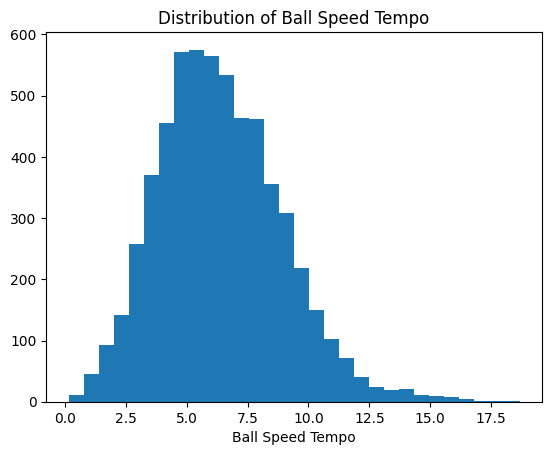

In [12]:
plotTempo(model_df=model_df_filtered)

## 3 Methods : Statistical Learning

### 3.1 Bayesian Hierarchical Model

We define $y_{ij}$ as the ball speed in an individual possesion. Speed is a non-zero positive value in our analysis, so an appropriate distribution for it is the Gamma distribution ([what is the gamma distribution?](https://en.wikipedia.org/wiki/Gamma_distribution)).

$$y_{ij} \sim Gamma(\mu_{ij}, \alpha_{ij}) $$

$$log(\mu_{ij}) = \upsilon_0 + X\beta$$

$$log (\alpha_{ij}) = \phi_0 + \delta_ij$$

To keep our model simple and intuitive for this hackathon, we let the priors ([what is a prior?](https://en.wikipedia.org/wiki/Prior_probability)) follow the default distributions set by `bambi`. In the future, we hope to fine tune our model to improve inference.

Predictor List

- Team Phase of Play (i.e. Finish, Build Up etc.)
- Game State (Winning, Losing, or Drawing)
- Separation (in metres) from Opposition Defender
- Number of Passing Options available for Player

**Note:** We want to include an opposition random effect in the model to capture the latent defensive characteristics opposition teams show (i.e. pressing intensity, man-marking etc.). However, due to a small sample size of matches, the model does not converge as there are not enough matches for each opposition team.

### Why is this novel?

Most applied football analytics projects are focused on modeling the mean of a variable. In our model framework, we model the variance of the response variable using a statistically powerful hierarchical framework. This type of work is very rare in sports analytics. One of the first papers that uses a similar framework was applied to American Football Analytics (see [paper](https://academic.oup.com/jrsssa/advance-article/doi/10.1093/jrsssa/qnaf185/8315856) and [coverage by NBC Sports](https://www.nbcsports.com/nfl/profootballtalk/rumor-mill/news/snap-timing-unpredictability-emerges-as-a-potentially-relevant-qb-metric))

We now train our model below:

In [13]:
tempo_formula = bmb.Formula('''ball_speed_tempo ~ 1
                                                + separation_start
                                                + n_passing_options
                                                + n_off_ball_runs
                                                + game_state
                                                + team_phase
                                                + (1 | player_short_name)
                            ''',
                            "alpha ~ (1 | player_short_name)")

model = bmb.Model(
    formula = tempo_formula,
    data = model_df_filtered,
    family = "gamma",
    link = "log",
    categorical = ["player_short_name", "game_state", "team_phase"]
)

idata = model.fit(
    draws=4000,
    tune=4000,
    target_accept=0.90,
    idata_kwargs={"log_likelihood": True}
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, separation_start, n_passing_options, n_off_ball_runs, game_state, team_phase, 1|player_short_name_sigma, 1|player_short_name_offset, alpha_Intercept, alpha_1|player_short_name_sigma, alpha_1|player_short_name_offset]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 80 seconds.


### 3.2 Model Results

- code to show the predictor/random effects for each predictor
- code to show the player rankings for each metric
- higher the more variance, lower the less variance

In [14]:
fixedEffects(trace = idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,exponentiated_mean
Intercept,2.117,0.021,2.076,2.157,0.0,0.0,11627.0,12329.0,1.0,8.31
separation_start,-0.007,0.001,-0.010,-0.004,0.0,0.0,16703.0,12956.0,1.0,0.99
n_passing_options,-0.067,0.004,-0.074,-0.059,0.0,0.0,24908.0,12689.0,1.0,0.94
n_off_ball_runs,0.018,0.007,0.005,0.030,0.0,0.0,22990.0,12966.0,1.0,1.02
game_state[losing],0.010,0.014,-0.016,0.035,0.0,0.0,16080.0,11848.0,1.0,1.01
game_state[winning],-0.016,0.014,-0.042,0.010,0.0,0.0,20307.0,13129.0,1.0,0.98
team_phase[chaotic or disruption],-0.276,0.031,-0.333,-0.218,0.0,0.0,19383.0,12768.0,1.0,0.76
team_phase[create],-0.023,0.014,-0.050,0.004,0.0,0.0,11797.0,12813.0,1.0,0.98
team_phase[fast or long],-0.052,0.026,-0.103,-0.005,0.0,0.0,15821.0,12161.0,1.0,0.95
team_phase[finish],-0.131,0.017,-0.163,-0.098,0.0,0.0,11282.0,12757.0,1.0,0.88


Based on this findings, the model esimtates eight predictors to reduce ball speed tempo for a possession (negative mean values). Two predictors are associated with a positive relationship with tempo.

Example Interpretations:
- One extra off ball runs increase the ball speed by ~2% (100% $\times$ [1.02 - 1]) for a given player possession
- Ball speed tempo typically decreases by 12% when the players' team is in the "Finish" phase of play as defined by SkillCorner (reference level: )

The credible intervals suggest the following demonstrate a statisticall sound relationship with tempo in our data sample:

- Separation
- Passing Options
- 

### Player Rankings

In [15]:
playerRankings(trace=idata, hdi = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1|player_short_name[M. Sutton],-0.510,0.127,-0.752,-0.262,0.001,0.001,22249.0,11795.0,1.0
alpha_1|player_short_name[N. Velupillay],-0.426,0.143,-0.703,-0.146,0.001,0.001,24453.0,12068.0,1.0
alpha_1|player_short_name[Douglas Costa],-0.417,0.156,-0.722,-0.116,0.001,0.001,20357.0,12050.0,1.0
alpha_1|player_short_name[A. Paulsen],-0.408,0.138,-0.683,-0.145,0.001,0.001,26142.0,12600.0,1.0
alpha_1|player_short_name[P. Retre],-0.397,0.165,-0.732,-0.091,0.001,0.001,24848.0,12391.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha_1|player_short_name[Z. de Jesus],0.289,0.190,-0.069,0.669,0.001,0.002,21860.0,10535.0,1.0
alpha_1|player_short_name[T. Uskok],0.329,0.175,-0.011,0.668,0.001,0.002,24597.0,10958.0,1.0
alpha_1|player_short_name[H. Bility],0.366,0.165,0.033,0.683,0.001,0.001,25707.0,11491.0,1.0
alpha_1|player_short_name[S. Souprayen],0.386,0.104,0.185,0.591,0.001,0.001,21312.0,12109.0,1.0


### Visualize Results

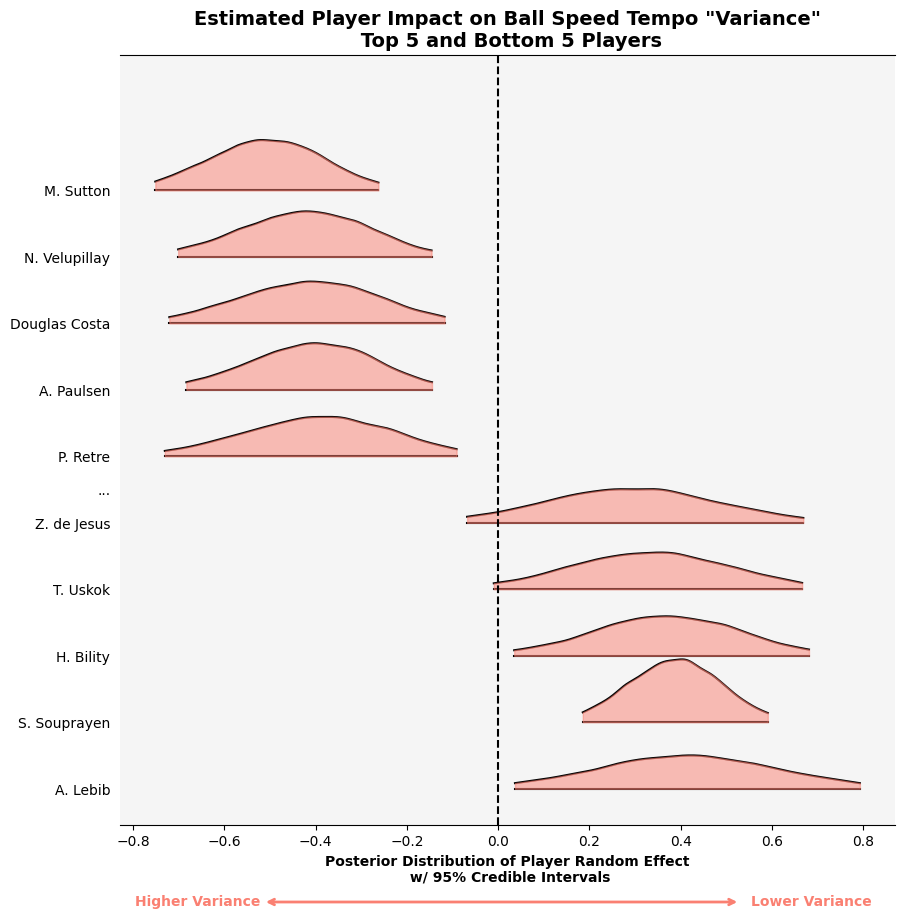

In [16]:
visualizeEstimatedPlayerImpact(trace = idata, k = 5)

## 4 Conclusions


**Future:** We are concurrently working on applying this methodology to publicly available World Cup 2022 tracking data to quantify tempo variability for players across the globe. 

The ultimate goal is to publish in an Open Access sports journal and package our work such that football practitioners will be able to use it in their analysis :)